# Load Species Tree and Transfers

In [1]:
from ete3 import Tree
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [2]:
species_tree = Tree("../supplements/FigS1_species_tree.newick",format=8)

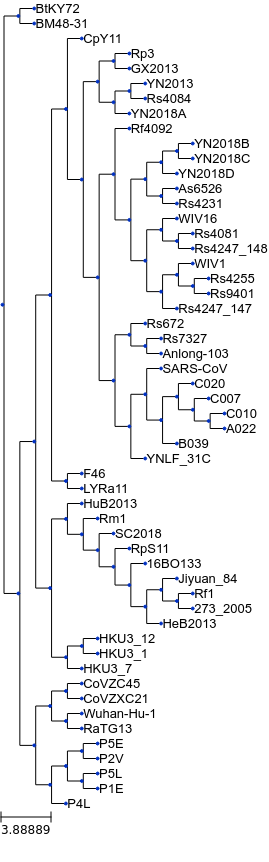

In [3]:
species_tree.render("%%inline")  

In [4]:
transfers = pd.read_csv('clean_transfer_table.csv')
# Uncomment to run with supplementary table
# transfers = pd.read_csv('../supplements/TabS2_transfers.csv')

In [5]:
transfers.head()

,Donor,Recipient,Gene Family,Support
0,GX2013,n44,S,1000
1,n15,YN2018A,S,1000
2,Rp3,Rm1,S,1000
3,HKU3_7,GX2013,ORF7a,1000
4,LYRa11,CpY11,ORF7a,1000


# Count Transfers at Each Node

In [6]:
def get_transfers(tlist, node_name, in_or_out="in", thresh=0):
    if in_or_out == "in":
        in_or_out = "Recipient"
    elif in_or_out == "out":
        in_or_out = "Donor"
    else:
        raise ValueError("in_or_out must be 'in' or 'out'")
    transfer_list = tlist[(tlist[in_or_out] == node_name) & (tlist["Support"] >= thresh)]
    return transfer_list

class NodeTransfers:
    def __init__(self,name):
        self.name = name
        self.selfIn = 0    # Number of transfers as recipient
        self.selfOut = 0   # Number of transfers as donor
        self.treeIn = 0    # Number of transfers with any node in subtree as recipient
        self.treeOut = 0   # Number of transfers with any node in subtree as donor
        self.len = 0       # Size of subtree rooted here
    
    def __repr__(self):
        return ' '.join(['{:.2f}'.format(i) for i in list(self.__dict__.values())[1:]])

In [7]:
transferDict = {}
threshold = 100

for node in species_tree.traverse("postorder"):
    nt = NodeTransfers(node.name)
    nt.name = node.name
    nt.selfIn = len(get_transfers(transfers,node.name,'in',threshold))
    nt.selfOut = len(get_transfers(transfers,node.name,'out',threshold))
    nt.treeIn = nt.selfIn
    nt.treeOut = nt.selfOut
    nt.length = len(node)
    for c in node.children:
        nt.treeIn += transferDict[c.name].treeIn
        nt.treeOut += transferDict[c.name].treeOut
    node.nt = nt
    transferDict[node.name] = nt

In [8]:
names = []
lens = []
inList = []
outList = []
bothList = []
inTreeList = []
outTreeList = []
bothTreeList = []

for nt in transferDict.values():
    names.append(nt.name)
    lens.append(nt.length)
    inList.append(nt.selfIn)
    outList.append(nt.selfOut)
    bothList.append(nt.selfIn + nt.selfOut) # Transfers as donor or recipient
    inTreeList.append(nt.treeIn)
    outTreeList.append(nt.treeOut)
    bothTreeList.append(nt.treeIn + nt.treeOut) # Transfers in subtree as donor or recipient

# Display Relationship between Number of Transfers and Clade Size

In [9]:
r, pval = pearsonr(lens,bothTreeList)
print(f"# Pearson R: {r}\n# Pearson P-Value: {pval}")
lr0 = LinearRegression()
lr0.fit(np.array(lens).reshape(-1,1),bothTreeList)
coef, intercept = lr0.coef_, lr0.intercept_
print(f"# Number Transfers ~= {coef[0]:.3f}*(Clade Size) + {intercept:.3f}")

# Pearson R: 0.9873425484102775
# Pearson P-Value: 8.476892448781874e-86
# Number Transfers ~= 23.784*(Clade Size) + -16.152


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


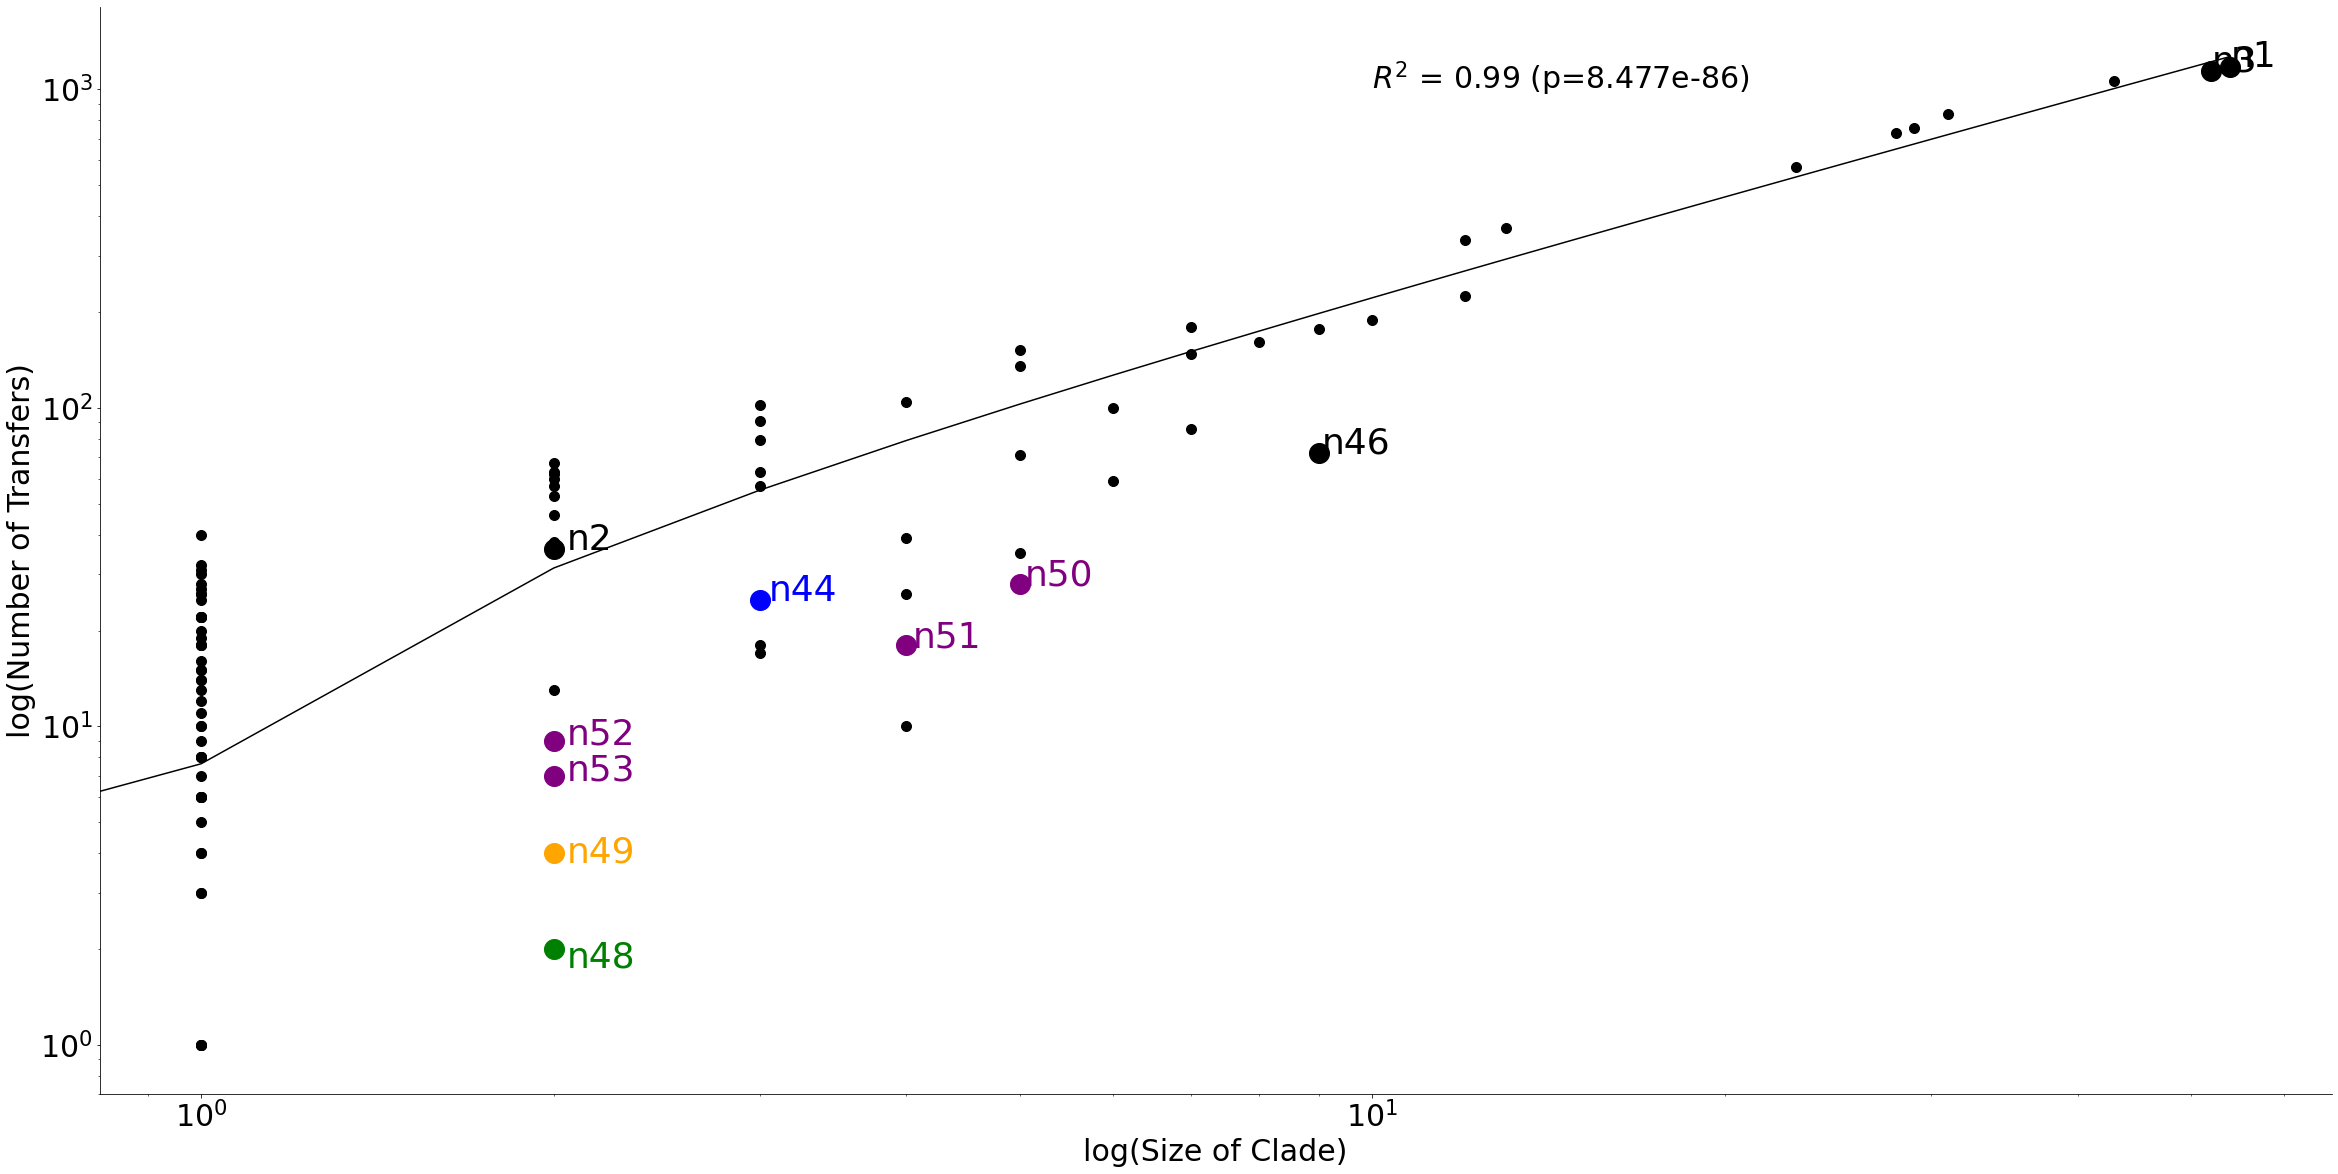

In [10]:
fig = plt.gcf()
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)
plt.xscale('log')
plt.yscale('log')
fig.set_size_inches(40, 20)
plt.plot(np.arange(0,max(lens)+1), coef * np.arange(0,max(lens)+1) + intercept, color='black')
for n, x, y in zip(names, lens, bothTreeList):
    if n == 'n48':
        # Ancestor of Zhejiang clade, Green
        plt.plot(x,y,'ro',label=n,c='green',markersize=20)
        plt.text(x=x + .05, y=y - .25, s=n, fontsize='large',c='green')
    elif n == 'n49':
        # Direct ancestor of RaTG-13 and SARS-CoV-2, Orange
        plt.plot(x,y,'ro',label=n,c='orange',markersize=20)
        plt.text(x=x + .05, y=y - .25, s=n, fontsize='large',c='orange')
    elif n in ['n50','n51','n52','n53']:
        # Ancestor of Pangolin clade, Purple
        plt.plot(x,y,'ro',label=n,c='purple',markersize=20)
        plt.text(x=x + .05, y=y - .25, s=n, fontsize='large',c='purple')
    elif n == 'n44':
        # Ancestor of HKU clade, Blue
        plt.plot(x,y,'ro',label=n,c='blue',markersize=20)
        plt.text(x=x + .05, y=y - .25, s=n, fontsize='large',c='blue')
    elif n in ['','n2','n3','n46']:
        # These are nodes that are ancestors of SARS-CoV-2
        if n == '': n = 'n1' # Special case for root of tree
        plt.plot(x,y,'ro',label=n,c='black',markersize=20)
        plt.text(x=x + .05, y=y - .25, s=n, fontsize='large',c='black')
    elif n.startswith('n'):
        # These are other ancestral nodes
        plt.plot(x,y,'ro',label=n,c='black',markersize=10)
    else:
        # These are other leaves
        plt.plot(x,y,'ro',label=n,c='black',markersize=10)
plt.text(x=10, y= 1000, s='$R^2$ = {:.2f} (p={:.3e})'.format(r, pval),c='black')
plt.xlabel('log(Size of Clade)')
plt.ylabel('log(Number of Transfers)')
sns.despine()

plt.show()